# State Tax Board - Liquor Sales Assesment

We are considering changes to the Iowa liquor tax rates and want to asses the impact of a given change to the tax rate.

As it stands today, we have no visibility into total liquor sales in the state and are unable to project the degree to which an increase or decrease of the liquor tax, would impact state revenues.

Using the liquor sales data, we will calculate the totals for 2015 and use Linear Regression methods to predict the sales for the rest of the year. Our goal will be to develop a model that provides good insight into future liquor sales and will allow the Tax Board the ability to make an informed assesment.

### Data Import & Cleaning

In [62]:
% matplotlib inline

from collections import defaultdict
import datetime

from matplotlib import pyplot as plt
# Make the plots bigger
plt.rcParams['figure.figsize'] = 15, 15
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn import linear_model

In [2]:
# Load the data
# *NOTE* Very slow, 2.9GB file.
df = pd.read_csv("/Users/gregorymaclennan/source_files/Iowa_Liquor_Sales.csv") # read the files to a Pandas DataFrame

print df.columns

df.head()

/Users/admin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index([u'Invoice/Item Number', u'Date', u'Store Number', u'Store Name',
       u'Address', u'City', u'Zip Code', u'Store Location', u'County Number',
       u'County', u'Category', u'Category Name', u'Vendor Number',
       u'Vendor Name', u'Item Number', u'Item Description', u'Pack',
       u'Bottle Volume (ml)', u'State Bottle Cost', u'State Bottle Retail',
       u'Bottles Sold', u'Sale (Dollars)', u'Volume Sold (Liters)',
       u'Volume Sold (Gallons)'],
      dtype='object')


,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,...,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,S29198800001,11/20/2015,2191,Keokuk Spirits,1013 MAIN,KEOKUK,52632,"1013 MAIN\nKEOKUK 52632\n(40.39978, -91.387531)",56.0,Lee,...,297,Templeton Rye w/Flask,6,750,$18.09,$27.14,6,$162.84,4.50,1.19
1,S29195400002,11/21/2015,2205,Ding's Honk And Holler,900 E WASHINGTON,CLARINDA,51632,"900 E WASHINGTON\nCLARINDA 51632\n(40.739238, ...",73.0,Page,...,297,Templeton Rye w/Flask,6,750,$18.09,$27.14,12,$325.68,9.00,2.38
2,S29050300001,11/16/2015,3549,Quicker Liquor Store,1414 48TH ST,FORT MADISON,52627,"1414 48TH ST\nFORT MADISON 52627\n(40.624226, ...",56.0,Lee,...,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,20,150,$6.40,$9.60,2,$19.20,0.30,0.08
3,S28867700001,11/04/2015,2513,Hy-Vee Food Store #2 / Iowa City,812 S 1ST AVE,IOWA CITY,52240,812 S 1ST AVE\nIOWA CITY 52240\n,52.0,Johnson,...,237,Knob Creek w/ Crystal Decanter,3,1750,$35.55,$53.34,3,$160.02,5.25,1.39
4,S29050800001,11/17/2015,3942,Twin Town Liquor,104 HIGHWAY 30 WEST,TOLEDO,52342,"104 HIGHWAY 30 WEST\nTOLEDO 52342\n(41.985887,...",86.0,Tama,...,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,20,150,$6.40,$9.60,2,$19.20,0.30,0.08


NameError: name 'df' is not defined

## Cleaning the data

Tasks completed in the following section
* Removed redundant columns
* Removed "$" prices from characters and convert values to floats.
* Converted dates to pandas datetime objects
* Converted category floats to integers
* Dropped or filled in bad values

In [31]:
# Review the column data types
print df.dtypes

Invoice/Item Number              object
Date                     datetime64[ns]
Store Number                      int64
Store Name                       object
Address                          object
City                             object
Zip Code                         object
Store Location                   object
County Number                   float64
Category                        float64
Vendor Number                   float64
Vendor Name                      object
Item Number                       int64
Pack                              int64
Bottle Volume (ml)                int64
State Bottle Cost               float64
State Bottle Retail             float64
Bottles Sold                      int64
Sale (Dollars)                  float64
Volume Sold (Liters)            float64
Volume Sold (Gallons)           float64
dtype: object


In [4]:
# Remove redundant columns
del df["Category Name"]
del df["Item Description"]
del df["County"]

In [23]:
# Remove $ from certain columns
cols = ["State Bottle Cost", "State Bottle Retail", "Sale (Dollars)"]

for col in cols:
    df[col] = df[col].str.replace(r'$', '').astype(float) # used regex to remove the '$' then converted to type float.

In [25]:
df.dtypes # check to make sure that the regex was successful

Invoice/Item Number              object
Date                     datetime64[ns]
Store Number                      int64
Store Name                       object
Address                          object
City                             object
Zip Code                         object
Store Location                   object
County Number                   float64
Category                        float64
Vendor Number                   float64
Vendor Name                      object
Item Number                       int64
Pack                              int64
Bottle Volume (ml)                int64
State Bottle Cost               float64
State Bottle Retail             float64
Bottles Sold                      int64
Sale (Dollars)                  float64
Volume Sold (Liters)            float64
Volume Sold (Gallons)           float64
dtype: object

In [26]:
# Convert dates
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")

In [32]:
# Drop bad values
df = df.dropna()

# Convert integers
df["County Number"] = df["County Number"].astype(int)
df["Category"] = df["Category"].astype(int)
df.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,Category,...,Vendor Name,Item Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
6,S28865700001,2015-11-09,2538,Hy-Vee Food Store #3 / Waterloo,1422 FLAMMANG DR,WATERLOO,50702,"1422 FLAMMANG DR\nWATERLOO 50702\n(42.459938, ...",7,1701100,...,Duggan's Distillers Products Corp,238,6,1500,11.62,17.43,6,104.58,9.0,2.38
8,S29339300091,2015-11-30,2662,Hy-Vee Wine & Spirits / Muscatine,"522 MULBERRY, SUITE A",MUSCATINE,52761,"522 MULBERRY, SUITE A\nMUSCATINE 52761\n",70,1701100,...,Jim Beam Brands,173,12,750,19.58,29.37,4,117.48,3.0,0.79
13,S28866900001,2015-11-11,3650,"Spirits, Stogies and Stuff",118 South Main St.,HOLSTEIN,51025,118 South Main St.\nHOLSTEIN 51025\n(42.490073...,47,1701100,...,Duggan's Distillers Products Corp,238,6,1500,11.62,17.43,1,17.43,1.5,0.40
18,S29134300126,2015-11-18,3723,J D Spirits Liquor,1023 9TH ST,ONAWA,51040,"1023 9TH ST\nONAWA 51040\n(42.025841, -96.095845)",67,1081200,...,MHW Ltd,258,1,6000,99.00,148.50,1,148.50,6.0,1.59
21,S29282800048,2015-11-23,2642,Hy-Vee Wine and Spirits / Pella,512 E OSKALOOSA,PELLA,50219,"512 E OSKALOOSA\nPELLA 50219\n(41.397023, -92....",63,1701100,...,Duggan's Distillers Products Corp,238,6,1500,11.62,17.43,6,104.58,9.0,2.38


In [33]:
# Export a cleaned but unfiltered version of the dataset
df.to_csv("/Users/gregorymaclennan/source_files/iowa_liquor_sales_pre_filter.csv")

## Filtering our data

Some stores may have opened or closed in 2015. These data points will heavily skew our models, so we need to filter them out or find a way to deal with them.

You'll need to provide a summary in your project report about these data points. You may also consider using the monthly sales in your model and including other information (number of months or days each store is open) in your data to handle these unusual cases.

Let's record the first and last sales dates for each store. We'll save this information for later when we fit our models.

In [34]:
# Determine which stores were open all of 2015
# Find the first and last sales date.
dates = df.groupby(by=["Store Number"], as_index=False)
dates = dates.agg({"Date": [np.min, np.max]})
dates.columns = [' '.join(col).strip() for col in dates.columns.values]
dates.head()

# Filter out stores that opened or closed throughout the year
# You may want to save this step until you start modelling
lower_cutoff = pd.Timestamp("20150301")
upper_cutoff = pd.Timestamp("20151001")
mask = (dates['Date amin'] < lower_cutoff) & (dates['Date amax'] > upper_cutoff)
good_stores = dates[mask]["Store Number"]
df = df[df["Store Number"].isin(good_stores)]

## Compute New Columns and Tables

Since we're trying to predict sales and/or profits, we'll want to compute some intermediate data. There are a lot of ways to do thisand good use of pandas is crucial. For example, for each transaction we may want to know:
* margin, retail cost minus bottle cost
* price per bottle
* price per liter

We'll need to make a new dataframe that indexes quantities by store:
* sales per store for all of 2015
* sales per store for Q1 2015
* sales per store for Q1 2016
* total volumes sold
* mean transaction revenue, gross margin, price per bottle, price per liter, etc.
* average sales per day
* number of days open

Make sure to retain other variables that we'll want to use to build our models, such as zip code, county number, city, etc. We recommend that you spend some time thinking about the model you may want to fit and computing enough of the suggested quantities to give you a few options.

Bonus tasks:
* Restrict your attention to stores that were open for all of 2015 and Q1 2016. Stores that opened or closed in 2015 will introduce outliers into your data.
* For each transaction we have the item category. You may be able to determine the store type (primarily wine, liquor, all types of alcohol, etc.) by the most common transaction category for each store. This could be a useful categorical variable for modelling. 

In [36]:
# Margin
df["Margin"] = (df["State Bottle Retail"] - df["State Bottle Cost"]) * df["Bottles Sold"]
df["Price per Liter"] = df["Sale (Dollars)"] / df["Volume Sold (Liters)"]
df.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,Category,...,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Margin,Price per Liter
6,S28865700001,2015-11-09,2538,Hy-Vee Food Store #3 / Waterloo,1422 FLAMMANG DR,WATERLOO,50702,"1422 FLAMMANG DR\nWATERLOO 50702\n(42.459938, ...",7,1701100,...,6,1500,11.62,17.43,6,104.58,9.0,2.38,34.86,11.62
8,S29339300091,2015-11-30,2662,Hy-Vee Wine & Spirits / Muscatine,"522 MULBERRY, SUITE A",MUSCATINE,52761,"522 MULBERRY, SUITE A\nMUSCATINE 52761\n",70,1701100,...,12,750,19.58,29.37,4,117.48,3.0,0.79,39.16,39.16
13,S28866900001,2015-11-11,3650,"Spirits, Stogies and Stuff",118 South Main St.,HOLSTEIN,51025,118 South Main St.\nHOLSTEIN 51025\n(42.490073...,47,1701100,...,6,1500,11.62,17.43,1,17.43,1.5,0.40,5.81,11.62
18,S29134300126,2015-11-18,3723,J D Spirits Liquor,1023 9TH ST,ONAWA,51040,"1023 9TH ST\nONAWA 51040\n(42.025841, -96.095845)",67,1081200,...,1,6000,99.00,148.50,1,148.50,6.0,1.59,49.50,24.75
21,S29282800048,2015-11-23,2642,Hy-Vee Wine and Spirits / Pella,512 E OSKALOOSA,PELLA,50219,"512 E OSKALOOSA\nPELLA 50219\n(41.397023, -92....",63,1701100,...,6,1500,11.62,17.43,6,104.58,9.0,2.38,34.86,11.62


In [37]:
# Sales per store, 2015

# Filter by our start and end dates
df.sort_values(by=["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20151231")
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
sales = df[mask]

# Group by store name
sales = sales.groupby(by=["Store Number"], as_index=False)
# Compute sums, means
sales = sales.agg({"Sale (Dollars)": [np.sum, np.mean],
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Margin": np.mean,
                   "Price per Liter": np.mean,
                   "Zip Code": lambda x: x.iloc[0], # just extract once, should be the same
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0]})
# Collapse the column indices
sales.columns = [' '.join(col).strip() for col in sales.columns.values]
# Rename columns
sales.columns = [u'Store Number', u'City', u'2015 Sales',
       u'2015 Sales mean', u'County Number',
       u'Price per Liter mean', u'Zip Code',
       u'2015 Volume Sold (Liters)', u'2015 Volume Sold (Liters) mean',
       u'2015 Margin mean']
# Quick check
sales.head()

,Store Number,City,2015 Sales,2015 Sales mean,County Number,Price per Liter mean,Zip Code,2015 Volume Sold (Liters),2015 Volume Sold (Liters) mean,2015 Margin mean
0,2106,CEDAR FALLS,1434021.94,281.070549,7,18.846731,50613,93982.72,18.420760,93.802281
1,2113,GOWRIE,85763.42,63.015004,94,17.625704,50543,6500.83,4.776510,21.082425
2,2130,WATERLOO,1108184.99,280.624206,7,17.506599,50703,65562.88,16.602401,93.612494
3,2152,ROCKWELL,72080.36,50.230216,17,13.043590,50469,6164.92,4.296111,16.824704
4,2178,WAUKON,277987.96,104.389020,3,16.594438,52172,21719.49,8.156023,35.011457


In [39]:
# Q1 sales, may want to also use aggregate as above to have more columns (means, etc.)

# Sales 2015  Q1
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20150331")
df.sort_values(by=["Store Number", "Date"], inplace=True)
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df2 = df[mask].groupby(by=["Store Number"], as_index=False)["Sale (Dollars)"].sum()
sales["2015 Sales Q1"] = df2["Sale (Dollars)"]

# Sales 2015  Q2
start_date = pd.Timestamp("20150401")
end_date = pd.Timestamp("20150630")
df.sort_values(by=["Store Number", "Date"], inplace=True)
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df2 = df[mask].groupby(by=["Store Number"], as_index=False)["Sale (Dollars)"].sum()
sales["2015 Sales Q2"] = df2["Sale (Dollars)"]

# Sales 2015  Q3
start_date = pd.Timestamp("20150701")
end_date = pd.Timestamp("20150930")
df.sort_values(by=["Store Number", "Date"], inplace=True)
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df2 = df[mask].groupby(by=["Store Number"], as_index=False)["Sale (Dollars)"].sum()
sales["2015 Sales Q3"] = df2["Sale (Dollars)"]

# Sales 2015  Q4
start_date = pd.Timestamp("20150930")
end_date = pd.Timestamp("20151231")
df.sort_values(by=["Store Number", "Date"], inplace=True)
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df2 = df[mask].groupby(by=["Store Number"], as_index=False)["Sale (Dollars)"].sum()
sales["2015 Sales Q4"] = df2["Sale (Dollars)"]

# Sales 2016 Q1
start_date = pd.Timestamp("20160101")
end_date = pd.Timestamp("20160331")
df.sort_values(by=["Store Number", "Date"], inplace=True)
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df2 = df[mask].groupby(by=["Store Number"], as_index=False)["Sale (Dollars)"].sum()
sales["2016 Sales Q1"] = df2["Sale (Dollars)"]

sales.head()

,Store Number,City,2015 Sales,2015 Sales mean,County Number,Price per Liter mean,Zip Code,2015 Volume Sold (Liters),2015 Volume Sold (Liters) mean,2015 Margin mean,2015 Sales Q1,2016 Sales Q1,2015 Sales Q2,2015 Sales Q3,2015 Sales Q4
0,2106,CEDAR FALLS,1434021.94,281.070549,7,18.846731,50613,93982.72,18.420760,93.802281,337166.53,337804.05,372579.22,335770.52,388505.67
1,2113,GOWRIE,85763.42,63.015004,94,17.625704,50543,6500.83,4.776510,21.082425,22351.86,21736.63,23468.56,18796.97,23026.33
2,2130,WATERLOO,1108184.99,280.624206,7,17.506599,50703,65562.88,16.602401,93.612494,277764.46,306942.27,277445.42,249453.87,303521.24
3,2152,ROCKWELL,72080.36,50.230216,17,13.043590,50469,6164.92,4.296111,16.824704,16805.11,9307.75,18259.91,21051.79,15963.55
4,2178,WAUKON,277987.96,104.389020,3,16.594438,52172,21719.49,8.156023,35.011457,54411.42,58939.90,77838.96,66304.06,83133.46


(0, 50000)

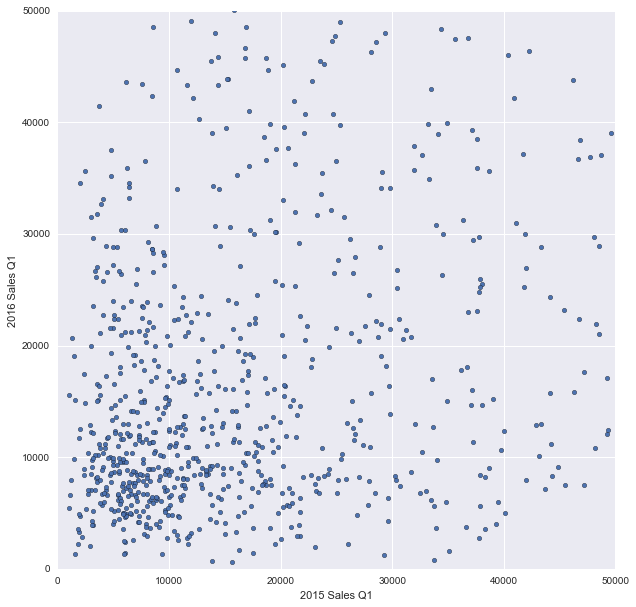

In [40]:
# Quick plot to check the computations
sales.plot(kind='scatter', x="2015 Sales Q1", y="2016 Sales Q1");
plt.xlim(0, 50000)
plt.ylim(0, 50000)

Proceed with any calculations that you need for your models, such as grouping
sales by zip code, most common vendor number per store, etc. Once you have finished adding columns, be sure to save the dataframe.

In [41]:
# Save this dataframe

# Let's add the dates computed above to this data.
sales["First Date"] = dates['Date amin']
sales["Last Date"] = dates['Date amax']

sales.to_csv("/Users/gregorymaclennan/source_files/iowa_liquor_sales_modified.csv")

In [42]:
# Load the data from the previous lab
# If you changed the name you'll need to edit the next line
sales = pd.read_csv("/Users/gregorymaclennan/source_files/iowa_liquor_sales_modified.csv")
sales.dropna(inplace=True)
del sales['Unnamed: 0']

# Convert dates
sales['First Date'] = pd.to_datetime(sales['First Date'], format="%Y-%m-%d")
sales['Last Date'] = pd.to_datetime(sales['Last Date'], format="%Y-%m-%d")
sales.head()

,Store Number,City,2015 Sales,2015 Sales mean,County Number,Price per Liter mean,Zip Code,2015 Volume Sold (Liters),2015 Volume Sold (Liters) mean,2015 Margin mean,2015 Sales Q1,2016 Sales Q1,2015 Sales Q2,2015 Sales Q3,2015 Sales Q4,First Date,Last Date
0,2106,CEDAR FALLS,1434021.94,281.070549,7,18.846731,50613,93982.72,18.420760,93.802281,337166.53,337804.05,372579.22,335770.52,388505.67,2012-01-05,2016-11-17
1,2113,GOWRIE,85763.42,63.015004,94,17.625704,50543,6500.83,4.776510,21.082425,22351.86,21736.63,23468.56,18796.97,23026.33,2012-01-04,2016-11-29
2,2130,WATERLOO,1108184.99,280.624206,7,17.506599,50703,65562.88,16.602401,93.612494,277764.46,306942.27,277445.42,249453.87,303521.24,2012-01-05,2016-11-17
3,2152,ROCKWELL,72080.36,50.230216,17,13.043590,50469,6164.92,4.296111,16.824704,16805.11,9307.75,18259.91,21051.79,15963.55,2012-01-09,2012-04-23
4,2178,WAUKON,277987.96,104.389020,3,16.594438,52172,21719.49,8.156023,35.011457,54411.42,58939.90,77838.96,66304.06,83133.46,2012-01-09,2016-02-25


In [43]:
# Compute correlations
sales.columns
numeric_columns = ['2015 Sales',
       '2015 Sales mean', u'Price per Liter mean', u'2015 Volume Sold (Liters)',
       u'2015 Volume Sold (Liters) mean', u'2015 Margin mean',
       u'2015 Sales Q1', u'2015 Sales Q2', u'2015 Sales Q3', u'2015 Sales Q4', u'2016 Sales Q1']

sales[numeric_columns].corr()

,2015 Sales,2015 Sales mean,Price per Liter mean,2015 Volume Sold (Liters),2015 Volume Sold (Liters) mean,2015 Margin mean,2015 Sales Q1,2015 Sales Q2,2015 Sales Q3,2015 Sales Q4,2016 Sales Q1
2015 Sales,1.000000,0.455015,0.181437,0.993403,0.431800,0.454502,0.748270,0.995201,0.758480,0.775068,0.149971
2015 Sales mean,0.455015,1.000000,0.106192,0.444397,0.957177,0.999994,0.354377,0.432264,0.386099,0.476561,0.034073
Price per Liter mean,0.181437,0.106192,1.000000,0.144003,-0.078897,0.104999,0.156919,0.181045,0.154972,0.174282,-0.016481
2015 Volume Sold (Liters),0.993403,0.444397,0.144003,1.000000,0.441110,0.444017,0.761693,0.990262,0.765156,0.782682,0.168649
2015 Volume Sold (Liters) mean,0.431800,0.957177,-0.078897,0.441110,1.000000,0.957763,0.354005,0.413282,0.367516,0.451536,0.041460
2015 Margin mean,0.454502,0.999994,0.104999,0.444017,0.957763,1.000000,0.354004,0.431754,0.385709,0.476174,0.034025
2015 Sales Q1,0.748270,0.354377,0.156919,0.761693,0.354005,0.354004,1.000000,0.746504,0.728030,0.740832,0.139633
2015 Sales Q2,0.995201,0.432264,0.181045,0.990262,0.413282,0.431754,0.746504,1.000000,0.751762,0.763773,0.149664
2015 Sales Q3,0.758480,0.386099,0.154972,0.765156,0.367516,0.385709,0.728030,0.751762,1.000000,0.976771,0.149475
2015 Sales Q4,0.775068,0.476561,0.174282,0.782682,0.451536,0.476174,0.740832,0.763773,0.976771,1.000000,0.151973


### Outliars and Data Removal

In [44]:
# drop from dataset (questionable data) Q1'15 sales were $2MM, and total 2015 sales were $162k. Not possible
sales.drop(sales.index[979],inplace=True) 

# drop from dataset (questionable data) total 2015 sales were $8.7MM and Q1'15 sales were only $13k
sales.drop(sales.index[977],inplace=True) 

# Hypothesis is that the stores may have been labled incorrectly and they might be the same store,
# w/ two different ID's. 


Model fit: 0.936536948414


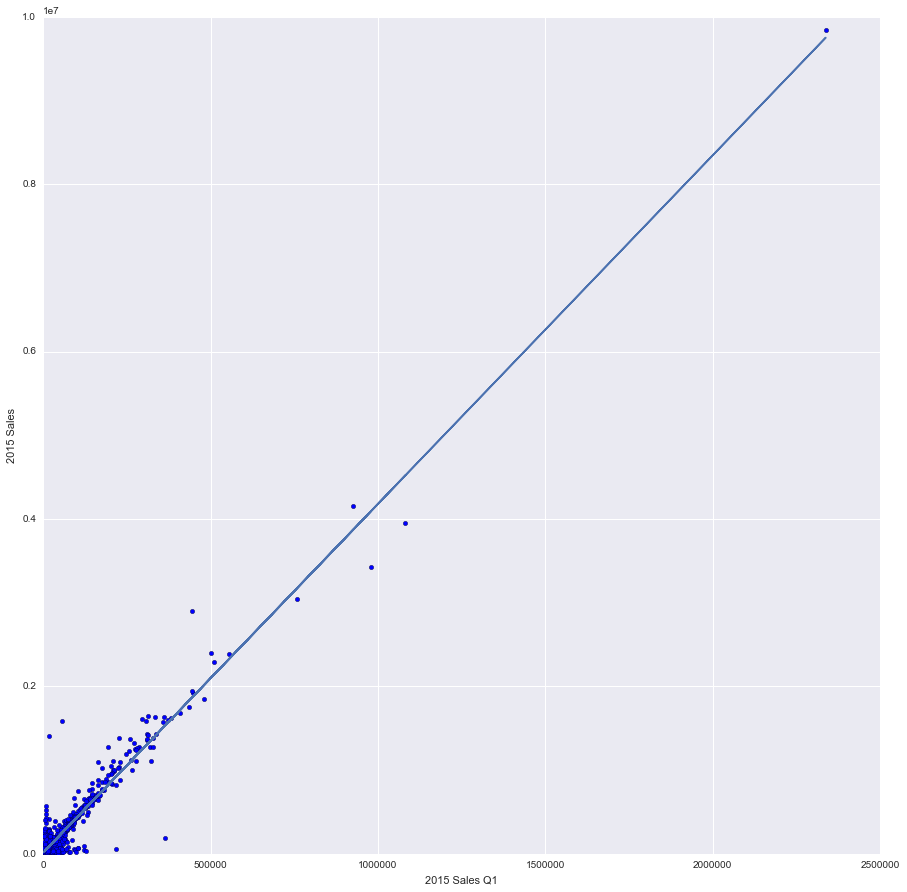

In [93]:
# Fit a linear model
lm = linear_model.LinearRegression()
X = sales[['2015 Sales Q1']]
# or you can do X = sales['2015 Sales Q1'].reshape(-1,1)
y = sales['2015 Sales']
lr_model = lm.fit(X,y)
lr_prediction = lm.predict(X)

print "Model fit:", lm.score(X, y)

# Plot the data and the best fit line
plt.scatter(X, y)
plt.plot(X, lr_prediction)
plt.xlabel('2015 Sales Q1')
plt.ylabel('2015 Sales')
plt.ylim(0, 10000000)
plt.xlim(0, 2500000)
plt.savefig('/Users/gregorymaclennan/source_files/sales_linear_regression.png')
plt.show()

In [73]:
# Predict Total 2016 sales, compare to 2015

# We already have a model above that's very accurate given Q1 sales for that given year.
# Now we'll use that model to take our information from Q1'16 to predict the total for 2016

# Take the sales from Q1'16
X = sales[['2016 Sales Q1']]
predictions = lm.predict(X) # run them through our model


pred_2016 = sum(predictions)
actual_2015 = sum(sales['2015 Sales'])
total_q1_15_sales = sum(sales['2015 Sales Q1'])
total_q1_16_sales = sum(sales['2016 Sales Q1'])

print "Total Sales (2015):", actual_2015
print "Predicted Sales (2016):", pred_2016
print "Total Sales (Q1'15):", total_q1_15_sales
print "Total Sales (Q1'16):", total_q1_16_sales

Total Sales (2015): 262204930.85
Predicted Sales (2016): 274848260.94
Total Sales (Q1'15): 58585061.13
Total Sales (Q1'16): 61620347.49


In [47]:
import plotly.plotly as py
import plotly.graph_objs as go

trace0 = go.Bar(
    x=["Q1'15","Q1'16"],
    y=[total_q1_15_sales, total_q1_16_sales],
    name='Q1 Sales',
    marker=dict(
        color='rgb(49,130,189)'
    )
)
trace1 = go.Bar(
    x=["2015 Total", "2016 Predicted"],
    y=[actual_2015, pred_2016],
    name='Annual Sales',
    marker=dict(
        color='rgb(204,204,204)',
    )
)

data = [trace0, trace1]
layout = go.Layout(
    xaxis=dict(tickangle=-45),
    barmode='group',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='angled-text-bar')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~gmaclenn/0 or inside your plot.ly account where it is named 'angled-text-bar'


In [87]:
# Created three different pivot tables.
# One for Zip Code, City and County Number
# MAKE SURE TO SWITCH THE AGG FUNC TO SUM
sales_by_zip = pd.pivot_table(sales, index='Zip Code', aggfunc=np.sum) 
sales_by_city = pd.pivot_table(sales, index='City', aggfunc=np.sum)
sales_by_county = pd.pivot_table(sales, index='County Number', aggfunc=np.sum)

# Sales by City

r^2 score: 0.989404555614


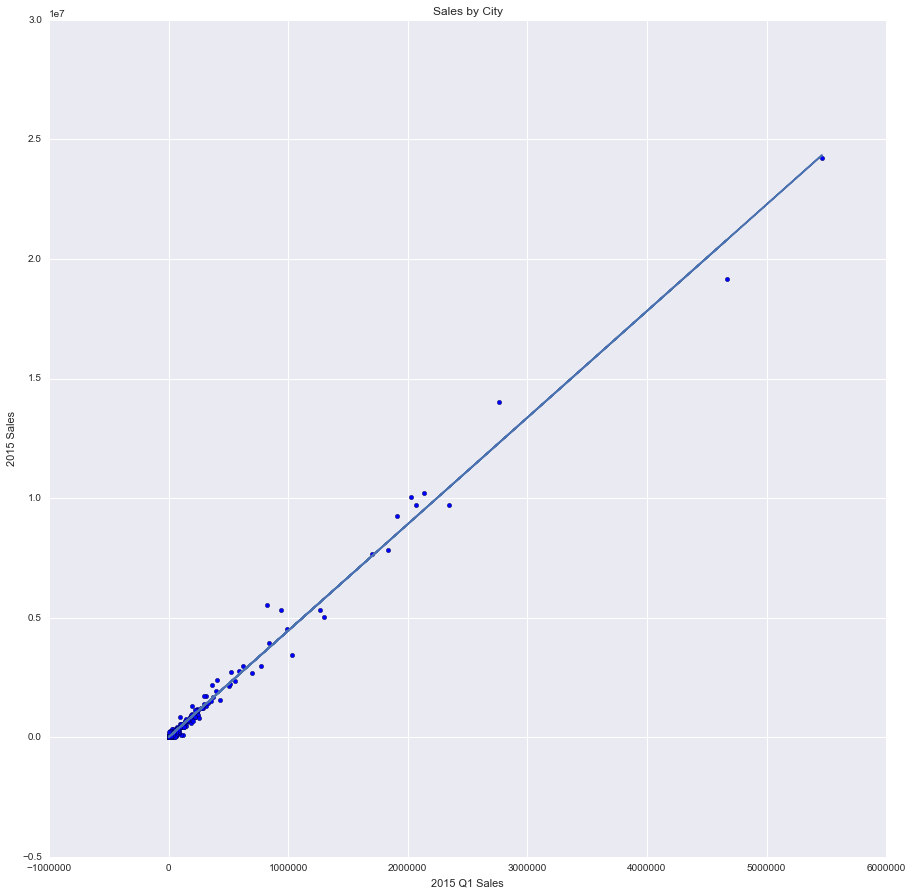

2016 Total Sales (predicted): 275725182.653


In [94]:
X = sales_by_city[['2015 Sales Q1']]
y = sales_by_city['2015 Sales']

lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
print 'r^2 score:', lm.score(X,y)
plt.scatter(X, y)
plt.plot(X, predictions)
plt.xlabel('2015 Q1 Sales')
plt.ylabel('2015 Sales')
plt.title('Sales by City')
plt.savefig('/Users/gregorymaclennan/source_files/sales_by_1.png')
plt.show()

X = sales_by_city[['2016 Sales Q1']]
predictions = lm.predict(X)

city_pred_2016 = sum(predictions)
print '2016 Total Sales (predicted):', city_pred_2016

# Sales by county

r^2 score: 0.994445372642


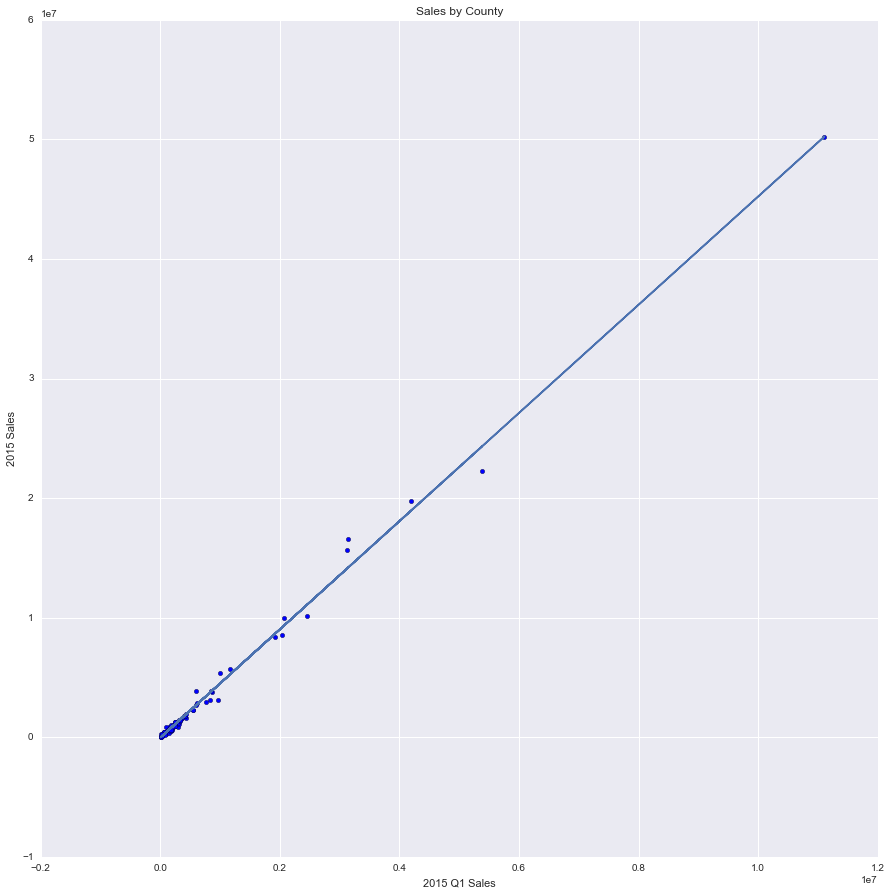

2016 Total Sales (predicted): 275939205.613


In [95]:
X = sales_by_county[['2015 Sales Q1']]
y = sales_by_county['2015 Sales']

lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
print 'r^2 score:', lm.score(X,y)
plt.scatter(X, y)
plt.plot(X, predictions)
plt.xlabel('2015 Q1 Sales')
plt.ylabel('2015 Sales')
plt.title('Sales by County')
plt.savefig('/Users/gregorymaclennan/source_files/sales_by_2.png')
plt.show()

X = sales_by_county[['2016 Sales Q1']]
predictions = lm.predict(X)

county_pred_2016 = sum(predictions)
print '2016 Total Sales (predicted):', county_pred_2016

# Sales by zip

r^2 score: 0.974712290752


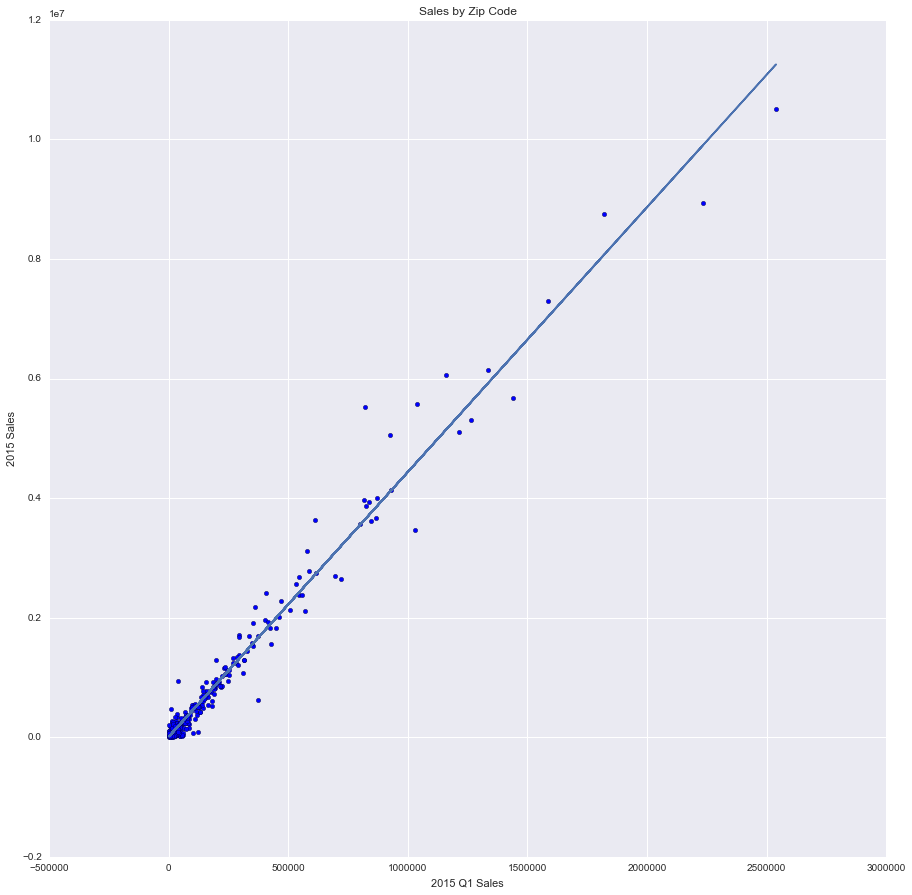

2016 Total Sales (predicted): 275646629.72


In [96]:
X = sales_by_zip[['2015 Sales Q1']]
y = sales_by_zip['2015 Sales']

lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
print 'r^2 score:', lm.score(X,y)
plt.scatter(X, y)
plt.plot(X, predictions)
plt.xlabel('2015 Q1 Sales')
plt.ylabel('2015 Sales')
plt.title('Sales by Zip Code')
plt.savefig('/Users/gregorymaclennan/source_files/sales_by_3.png')
plt.show()

X = sales_by_zip[['2016 Sales Q1']]
predictions = lm.predict(X)

zip_pred_2016 = sum(predictions)
print '2016 Total Sales (predicted):', zip_pred_2016

# Executive Summary

Report your findings, including any projected increase or decrease in total sales (over the entire state) for the tax committee of the Iowa legislature.

### Using data by store
* Model Fit: 0.936536948414
    * Total Sales (2015): \$262,204,930.85
    * Predicted Sales (2016): \$274,848,260.94
    * Total Sales (Q1'15): \$58,585,061.13
    * Total Sales (Q1'16): \$61,620,347.49

### Using data by county
* Model Fit: 0.994445372642
    * Predicted Sales (2016): \$275,939,205.61

### Using data by zip code
* Model Fit: 0.974712290752
    * Predicted Sales (2016): \$275,646,629.72

### Using data by city
* Model Fit: 0.989404555614
    * Predicted Sales (2016): \$275,725,182.65

#### If we use our best fitted model, the model fitted to our data by county, we are predicting a 5.1% sales increase in 2016. We predict total liquor sales in the state will increase to \$275.9MM, up from \$262.2MM in 2015. We project that there will be an additional \$13.5MM worth of additional taxable sales in 2016. At the current sales tax rate of 6% that would equate to another about \$811k in additional revenue for the state without any changes to the tax rate.

An increase to the sales tax rate of 0.25% would add an additional \$689k of additional revenue for the state.

Iowa is an "Alcoholic beverage control state", in which the sale of liquor and spirits are state-controlled. Liquor sales are only permitted in state alcohol stores, also called "ABC Stores". The state earns revenue by selling alcoholic beverages, so there is no need to apply an additional excise tax on liquor